### Imports

In [71]:
import json
import pickle
from itertools import chain
from tqdm import tqdm
import numpy as np
import pandas as pd
import graph_tool as gt
import graph_tool.all as gt

### Raw data parsing

In [10]:
def read_dataset(path):
    df = pd.read_json(path, lines=True)
    df.dropna(axis=0, how='any', subset=['author', 'text'], inplace=True)
    df.loc[df.comments.isnull(), ['comments']] = df.loc[df.comments.isnull(), 'comments'].apply(lambda x: [])
    return df

meme_df = read_dataset('../data/imgflip_ultra.jl')

### Graph

#### Graph initialization

In [20]:
meme_graph = gt.Graph()
meme_graph.vp.vertex_type = meme_graph.new_vertex_property('string')
meme_graph.vp.vertex_properties = meme_graph.new_vertex_property('string')
meme_graph.ep.edge_type = meme_graph.new_edge_property('string')

#### User vertices

In [21]:
user_names = []
for comments in meme_df.comments:
    for comment in comments:
        if 'author' in comment:
            user_names.append(comment['author'])

user_names = np.unique(np.append(np.array(user_names), meme_df.author.values))
user_vertices = meme_graph.add_vertex(len(user_names))
user_vertex_dict = dict(zip(user_names, user_vertices))


for user_name, user_vertex in user_vertex_dict.items():
    meme_graph.vp.vertex_type[user_vertex] = 'user'
    meme_graph.vp.vertex_properties[user_vertex] = json.dumps({'name': user_name})
    
    


#### Meme and comment vertices

In [22]:
meme_vertices = meme_graph.add_vertex(len(meme_df))

for (_, meme_srs), meme_vertex in tqdm(zip(meme_df.iterrows(), meme_vertices), total=len(meme_df)):
    meme_graph.vp.vertex_type[meme_vertex] = 'meme'
    meme_graph.vp.vertex_properties[meme_vertex] = json.dumps(meme_srs.loc[
        ['title', 'text', 'views', 'upvotes', 'hashtags', 'img_file', 'url']
    ].to_dict())
    
    author_vertex = user_vertex_dict[meme_srs.author]
    author_edge = meme_graph.add_edge(author_vertex, meme_vertex)
    meme_graph.ep.edge_type[author_edge] = 'authored'
    
    comments = meme_srs.comments
    comment_vertices = meme_graph.add_vertex(len(comments))
    if len(comments) == 1:
        comment_vertices = [comment_vertices]
    
    parent_comment_vertex_stack = [None]
    prev_comment_level = 0
    for idx, (comment, comment_vertex) in enumerate(zip(comments, comment_vertices)):            
        level = comment['level']
      
        if level == 0:
            concern_edge = meme_graph.add_edge(comment_vertex, meme_vertex)
        else:
            concern_edge = meme_graph.add_edge(comment_vertex, parent_comment_vertex_stack[-1])
                
        
        if level == prev_comment_level:
            parent_comment_vertex_stack[-1] = comment_vertex
        elif level > prev_comment_level:
            parent_comment_vertex_stack.append(comment_vertex)
        else:
            parent_comment_vertex_stack.pop()
            parent_comment_vertex_stack[-1] = comment_vertex
            
        prev_comment_level = level

        meme_graph.ep.edge_type[concern_edge] = 'concerns'
 
        meme_graph.vp.vertex_type[comment_vertex] = 'comment'
        meme_graph.vp.vertex_properties[comment_vertex] = json.dumps({'upvotes': comment.get('upvotes', 0)})
        
        if 'author' in comment:
            author_edge = meme_graph.add_edge(user_vertex_dict[comment['author']], comment_vertex)
            meme_graph.ep.edge_type[author_edge] = 'authored'
         

100%|██████████| 112042/112042 [02:48<00:00, 664.82it/s]


#### Saving and loading

In [24]:
with open('imgflip_meme_graph.pckl', 'wb') as f:
    pickle.dump(meme_graph, f)

In [2]:
with open('imgflip_meme_graph.pckl', 'rb') as f:
    meme_graph = pickle.load(f)

#### Visualization

In [ ]:
simple_g = gt.Graph()
v1, v2 = simple_g.add_vertex(2)
simple_g.add_edge(v1, v2)

gt.graph_draw(meme_graph)

#### Statistics

In [3]:
vertice_types = meme_graph.vp.vertex_type.get_2d_array([0])
types_count = np.unique(vertice_types, return_counts=True)

for t_name, count in zip(*types_count):
    if not t_name:
        continue
    print(f'There are {count} vertices of type {t_name}')

There are 726927 vertices of type comment
There are 112042 vertices of type meme
There are 26566 vertices of type user


In [5]:
vertice_hist_in = gt.vertex_hist(meme_graph, deg='in')
vertice_hist_out = gt.vertex_hist(meme_graph, deg='out')

In [6]:
import matplotlib.pyplot as plt

def draw_hist(gt_hist):
    plt.bar(gt_hist[1][1:], gt_hist[0])
    plt.yscale('log')
    plt.gcf().set_size_inches(15, 10)

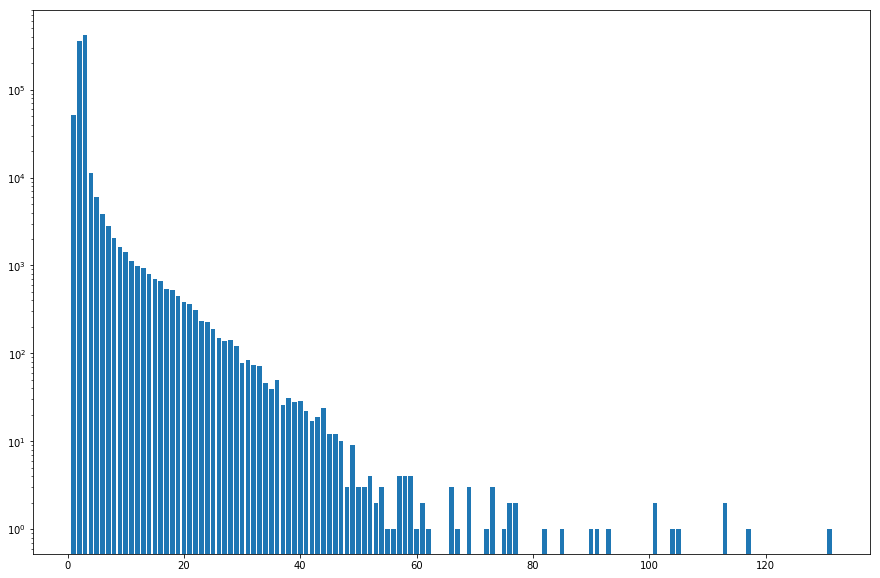

In [7]:
draw_hist(vertice_hist_in)

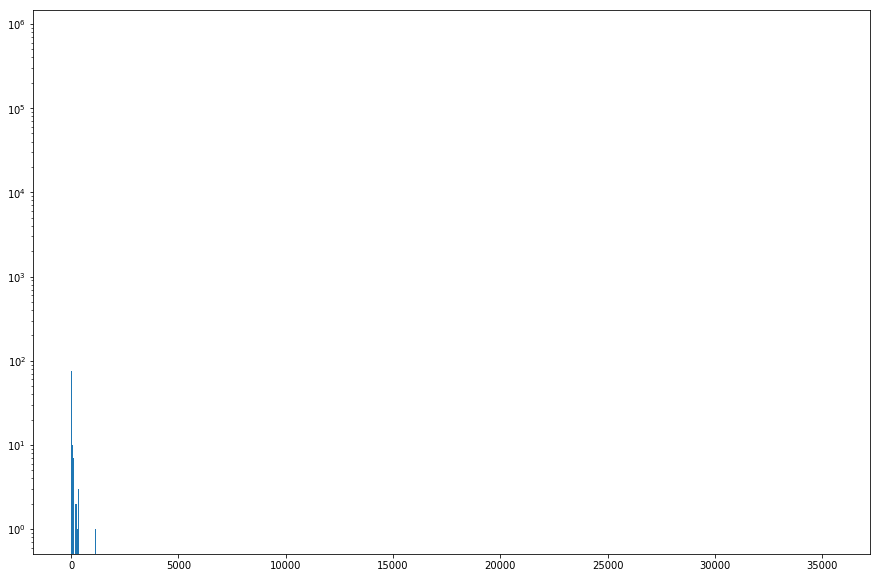

In [8]:
draw_hist(vertice_hist_out)

In [ ]:
bs = gt.centrality.betweenness(meme_graph)

#### Visualisation

Filtering

In [119]:
def get_most_popular_meme_graph(meme_df, meme_graph, num_memes=10):
    most_popular_idxs = meme_df.sort_values('views', ascending=False)[:num_memes].index
    most_popular_vertices = [meme_graph.vertex(idx) for idx in most_popular_idxs]

    connected_vertices = [
        n
        for v in most_popular_vertices 
        for n in v.all_neighbors()
    ]
    connected_vertices.extend([
        n
        for v in connected_vertices
        for n in v.all_neighbors()
        if meme_graph.vp.vertex_type[v] == 'comment'
    ])

    connected_edges = [
        e 
        for v in chain(most_popular_vertices, connected_vertices)
        for e in v.all_edges()
    ]

    vfilt = meme_graph.new_vertex_property('bool', val=False)
    for v in chain(most_popular_vertices, connected_vertices):
        vfilt[v] = True

    efilt = meme_graph.new_edge_property('bool', val=False)
    for e in set(connected_edges):
        efilt[e] = True

    meme_view = gt.GraphView(
        meme_graph,
        vfilt=vfilt,
        efilt=efilt
    )
    
    return meme_view

Drawing

In [128]:
def _type_to_color(type_):
    if type_ == 'meme':
        return 'red'
    if type_ == 'user':
        return 'blue'
    if type_ == 'comment':
        return 'green'
    
def draw_meme_graph(meme_graph):
    v_colors = meme_graph.new_vertex_property('string')
    for v in meme_graph.vertices():
        v_colors[v] = _type_to_color(meme_graph.vp.vertex_type[v])

    gt.graph_draw(
        meme_graph,
        vertex_fill_color=v_colors,
        edge_marker_size=10
    )

Putting it all together

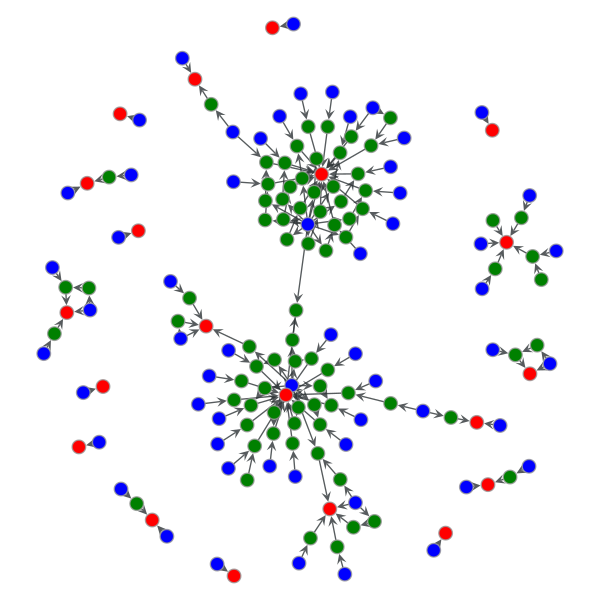

In [130]:
popular_meme_graph = get_most_popular_meme_graph(meme_df, meme_graph, 20)
draw_meme_graph(popular_meme_graph)